<a href="https://colab.research.google.com/github/tmtakashi/acoustic_analysis/blob/master/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# https://qiita.com/triwave33/items/1890ccc71fab6cbca87e
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from keras.models import Sequential
from keras.optimizers import Adam

import numpy as np

class GAN():
  def __init__(self):
    # MNISTの入力サイズ
    self.img_rows = 28
    self.img_cols = 28
    self.channels = 1
    self.img_shape = (self.img_rows, self.img_cols, self.channels)

    # 潜在変数の次元数
    self.z_dim =100

    optimizer = Adam(0.0002, 0.5)

    # Discriminatorモデル
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss='binary_crossentropy',
                               optimizer=optimizer,
                               metrics=['accuracy'])

    # Generatorモデル
    self.generator = self.build_generator()
    # Generatorは単体では学習しないのでコンパイルは必要ない

    self.combined = self.build_combined1()
    self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
  def build_generator(self):
    noise_shape = (self.z_dim, )
    model = Sequential()

    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(self.img_shape), activation='tanh'))
    model.add(Reshape(self.img_shape))


    model.summary()

    return model

  def build_discriminator(self):
    img_shape = (self.img_rows, self.img_cols, self.channels)

    model = Sequential()
    
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    return model

  def build_combined1(self):
    self.discriminator.trainable = False
    model = Sequential([self.generator, self.discriminator])
    return model

  def build_combined2(self):
    z = Input(shape=(self.z_dim,))
    img = self.generator(z)
    self.discriminator.trainable = False
    valid = self.discriminator(img)
    model = Model(z, valid)
    model.summary()
    return model

  def train(self, epochs, batch_size=128, save_interval=50):

    #　MNIST読み込み
    from keras.datasets import mnist
    (x_train, _), (_, _) = mnist.load_data()

    # 正規化
    x_train = x_train / 255.
    # チャンネル次元を増やす
    x_train = np.expand_dims(x_train, axis=3)

    half_batch = int(batch_size / 2)

    for epoch in range(epochs):

      # -------------------------
      # Discriminatorの学習
      # -------------------------

      # バッチサイズの半数をGeneratorから生成
      noise = np.random.normal(0, 1, (half_batch, self.z_dim))
      gen_imgs = self.generator.predict(noise)

      # バッチサイズの半数を教師データからピックアップ
      idx = np.random.randint(0, x_train.shape[0], half_batch)
      imgs = x_train[idx]

      # Discriminatorを学習
      # 本物データと偽物データは別々に学習させる
      d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1))) # 本物
      d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1))) # 偽物
      # それぞれの損失関数を平均
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      # -----------------------
      # Generatorの学習
      # -----------------------

      noise = np.random.normal(0, 1, (batch_size, self.z_dim))

      # 生成データの正解データは本物
      valid_y = np.array([1] * batch_size)

      # Generatorを学習
      g_loss = self.combined.train_on_batch(noise, valid_y)

      # 進捗の表示
      print("%d [ D loss: %f, acc.: %2.f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

In [36]:
model = GAN()
model.train(epochs=400)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_14 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_90 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_66 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_91 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_67 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_92 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [ D loss: 0.830534, acc.:  6%] [G loss: 0.755106]
1 [ D loss: 0.702389, acc.: 55%] [G loss: 0.795347]
2 [ D loss: 0.565958, acc.: 79%] [G loss: 0.905910]
3 [ D loss: 0.476690, acc.: 88%] [G loss: 0.987461]
4 [ D loss: 0.425834, acc.: 90%] [G loss: 1.040646]
5 [ D loss: 0.370454, acc.: 95%] [G loss: 1.123937]
6 [ D loss: 0.357645, acc.: 96%] [G loss: 1.222459]
7 [ D loss: 0.312498, acc.: 98%] [G loss: 1.317365]
8 [ D loss: 0.298509, acc.: 97%] [G loss: 1.378426]
9 [ D loss: 0.250113, acc.: 98%] [G loss: 1.478060]
10 [ D loss: 0.232984, acc.: 99%] [G loss: 1.525517]
11 [ D loss: 0.235929, acc.: 99%] [G loss: 1.603925]
12 [ D loss: 0.196523, acc.: 99%] [G loss: 1.748913]
13 [ D loss: 0.181352, acc.: 99%] [G loss: 1.795248]
14 [ D loss: 0.172067, acc.: 100%] [G loss: 1.905810]
15 [ D loss: 0.144358, acc.: 100%] [G loss: 1.928936]
16 [ D loss: 0.141118, acc.: 100%] [G loss: 2.032755]
17 [ D loss: 0.142047, acc.: 100%] [G loss: 2.042252]
18 [ D loss: 0.126934, acc.: 99%] [G loss: 2.150100]

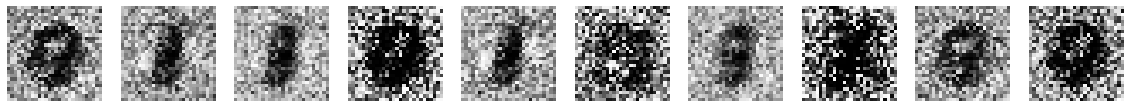

In [39]:
# 400 iteration
generated_img = model.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [40]:
model = GAN()
model.train(epochs=1000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_15 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_97 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_71 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_98 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_72 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_99 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [ D loss: 0.650426, acc.: 68%] [G loss: 0.746830]
1 [ D loss: 0.612718, acc.: 68%] [G loss: 0.794291]
2 [ D loss: 0.514570, acc.: 77%] [G loss: 0.890329]
3 [ D loss: 0.403434, acc.: 91%] [G loss: 1.064851]
4 [ D loss: 0.388591, acc.: 91%] [G loss: 1.142381]
5 [ D loss: 0.314430, acc.: 98%] [G loss: 1.263888]
6 [ D loss: 0.280230, acc.: 97%] [G loss: 1.353869]
7 [ D loss: 0.260382, acc.: 100%] [G loss: 1.445542]
8 [ D loss: 0.238112, acc.: 98%] [G loss: 1.525557]
9 [ D loss: 0.216331, acc.: 99%] [G loss: 1.624096]
10 [ D loss: 0.189460, acc.: 99%] [G loss: 1.694652]
11 [ D loss: 0.193149, acc.: 100%] [G loss: 1.750156]
12 [ D loss: 0.184444, acc.: 99%] [G loss: 1.846170]
13 [ D loss: 0.150240, acc.: 100%] [G loss: 1.889411]
14 [ D loss: 0.142256, acc.: 100%] [G loss: 1.995311]
15 [ D loss: 0.143178, acc.: 100%] [G loss: 2.098474]
16 [ D loss: 0.126450, acc.: 100%] [G loss: 2.183928]
17 [ D loss: 0.106118, acc.: 100%] [G loss: 2.205107]
18 [ D loss: 0.145411, acc.: 100%] [G loss: 2.345

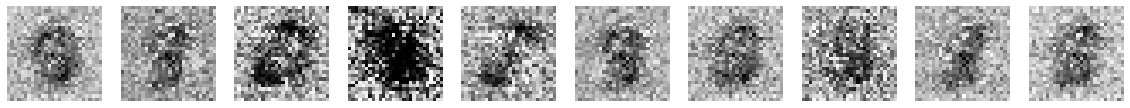

In [41]:
# 1000 iteration
generated_img = model.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [42]:
model = GAN()
model.train(epochs=5000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_16 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_104 (Dense)            (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_76 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_105 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_77 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_106 (Dense)            (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [ D loss: 0.745118, acc.: 25%] [G loss: 0.720588]
1 [ D loss: 0.718380, acc.: 59%] [G loss: 0.748566]
2 [ D loss: 0.570051, acc.: 75%] [G loss: 0.844547]
3 [ D loss: 0.453935, acc.: 88%] [G loss: 0.956982]
4 [ D loss: 0.482131, acc.: 80%] [G loss: 1.104053]
5 [ D loss: 0.369860, acc.: 96%] [G loss: 1.219124]
6 [ D loss: 0.321054, acc.: 96%] [G loss: 1.315813]
7 [ D loss: 0.306236, acc.: 98%] [G loss: 1.355426]
8 [ D loss: 0.261622, acc.: 98%] [G loss: 1.468564]
9 [ D loss: 0.239889, acc.: 100%] [G loss: 1.563174]
10 [ D loss: 0.209400, acc.: 100%] [G loss: 1.580536]
11 [ D loss: 0.193943, acc.: 100%] [G loss: 1.658775]
12 [ D loss: 0.189588, acc.: 100%] [G loss: 1.757692]
13 [ D loss: 0.176261, acc.: 100%] [G loss: 1.828839]
14 [ D loss: 0.162281, acc.: 99%] [G loss: 1.873948]
15 [ D loss: 0.171595, acc.: 100%] [G loss: 1.994511]
16 [ D loss: 0.142139, acc.: 100%] [G loss: 2.147608]
17 [ D loss: 0.131660, acc.: 100%] [G loss: 2.171350]
18 [ D loss: 0.124949, acc.: 100%] [G loss: 2.12

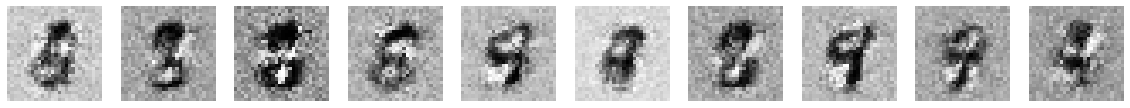

In [43]:
# 5000 iteration
generated_img = model.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [44]:
model = GAN()
model.train(epochs=10000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_17 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_111 (Dense)            (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_81 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_112 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_82 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_113 (Dense)            (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [ D loss: 0.724122, acc.: 51%] [G loss: 1.102927]
1 [ D loss: 0.534052, acc.: 84%] [G loss: 1.091428]
2 [ D loss: 0.467874, acc.: 92%] [G loss: 1.239087]
3 [ D loss: 0.348120, acc.: 98%] [G loss: 1.360638]
4 [ D loss: 0.329557, acc.: 98%] [G loss: 1.502756]
5 [ D loss: 0.264326, acc.: 100%] [G loss: 1.548258]
6 [ D loss: 0.245714, acc.: 100%] [G loss: 1.651626]
7 [ D loss: 0.204730, acc.: 99%] [G loss: 1.721277]
8 [ D loss: 0.204395, acc.: 100%] [G loss: 1.836136]
9 [ D loss: 0.212280, acc.: 99%] [G loss: 1.910343]
10 [ D loss: 0.176994, acc.: 100%] [G loss: 1.998255]
11 [ D loss: 0.153092, acc.: 99%] [G loss: 2.024286]
12 [ D loss: 0.136732, acc.: 100%] [G loss: 2.185439]
13 [ D loss: 0.145404, acc.: 100%] [G loss: 2.190495]
14 [ D loss: 0.121057, acc.: 100%] [G loss: 2.329449]
15 [ D loss: 0.126744, acc.: 100%] [G loss: 2.340208]
16 [ D loss: 0.116193, acc.: 100%] [G loss: 2.413522]
17 [ D loss: 0.102254, acc.: 100%] [G loss: 2.518327]
18 [ D loss: 0.091707, acc.: 100%] [G loss: 2.

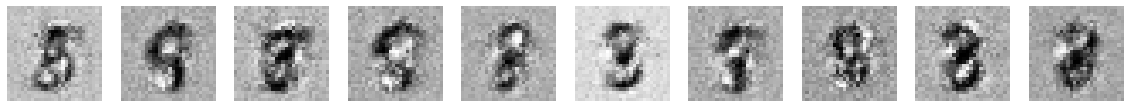

In [49]:
# 10000 iteration
generated_img = model.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [0]:
model = GAN()
model.train(epochs=15000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_19 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_125 (Dense)            (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_91 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_126 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_92 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_127 (Dense)            (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [ D loss: 0.674030, acc.: 64%] [G loss: 0.763732]
1 [ D loss: 0.643622, acc.: 66%] [G loss: 0.785033]
2 [ D loss: 0.535455, acc.: 75%] [G loss: 0.933655]
3 [ D loss: 0.453901, acc.: 84%] [G loss: 1.041255]
4 [ D loss: 0.379486, acc.: 94%] [G loss: 1.158961]
5 [ D loss: 0.310738, acc.: 98%] [G loss: 1.264643]
6 [ D loss: 0.322920, acc.: 93%] [G loss: 1.361583]
7 [ D loss: 0.273678, acc.: 99%] [G loss: 1.487244]
8 [ D loss: 0.251398, acc.: 98%] [G loss: 1.546515]
9 [ D loss: 0.227439, acc.: 100%] [G loss: 1.651034]
10 [ D loss: 0.202317, acc.: 99%] [G loss: 1.714586]
11 [ D loss: 0.171925, acc.: 100%] [G loss: 1.747761]
12 [ D loss: 0.168401, acc.: 99%] [G loss: 1.845441]
13 [ D loss: 0.174812, acc.: 100%] [G loss: 1.890058]
14 [ D loss: 0.142267, acc.: 100%] [G loss: 1.992876]
15 [ D loss: 0.133130, acc.: 100%] [G loss: 2.071599]
16 [ D loss: 0.129158, acc.: 100%] [G loss: 2.097140]
17 [ D loss: 0.136553, acc.: 100%] [G loss: 2.162015]
18 [ D loss: 0.124745, acc.: 100%] [G loss: 2.272

In [0]:
# 15000 iteration
generated_img = model.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [0]:
model = GAN()
model.train(epochs=20000)

In [0]:
# 20000 iteration
generated_img = model.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)